## summary

- $\sigma(x)$ 会导致梯度消失
- $\text{relu}(x)$ 会部分地改善梯度消失
    - 会诱导 sparse representation
    - dying relu / dead neuron
- `torch.clamp(x, min, max)`
    - relu/clamp 的 gradient 都是 0-1 组成的 mask tensor

## 从 $\sigma(x)$ 到 $\text{relu}(x)$

$$
\begin{split}
\sigma(x)&=\frac{1}{1+\exp(-x)}\\
\sigma'(x)&=\sigma(x)\cdot(1-\sigma(x))
\end{split}
$$

### $\sigma(x)$

In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

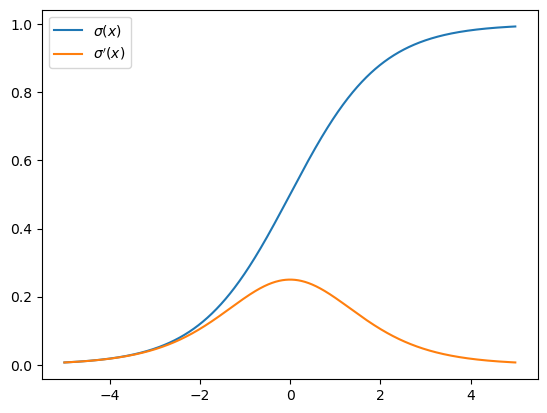

In [41]:
x = np.arange(-5, 5, .01)
plt.plot(x, sigmoid(x))
plt.plot(x, sigmoid_prime(x))
plt.legend(['$\sigma(x)$', "$\sigma'(x)$"])

### $\text{relu}(x)$

$$
\begin{split}
&y=\max(0, x)\\
&y'=\begin{cases}1 & x > 0, \\ 0 & x < 0.\end{cases}
\end{split}
$$

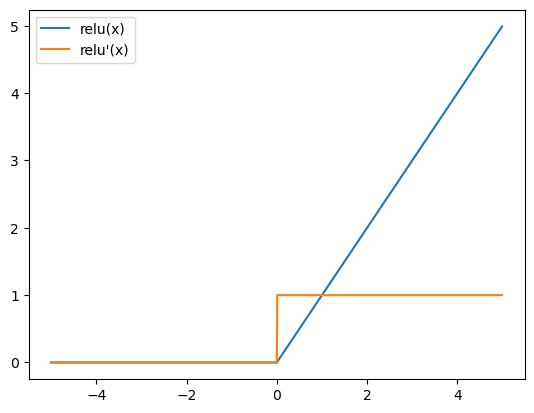

In [42]:
x = np.arange(-5, 5, 0.01)
def relu(x):
    return np.where(x > 0, x, 0)
def relu_prime(x):
    return np.where(x > 0, 1, 0)
plt.plot(x, relu(x))
plt.plot(x, relu_prime(x))
plt.legend(['relu(x)', "relu'(x)"])

#### 前向过程（forward）：sparse representation

In [43]:
import torch
from torch import nn

In [44]:
x = torch.normal(0, 1, (3, 5))
w = nn.Linear(5, 4)
w(x)

tensor([[ 0.2534,  0.2444,  0.0077, -0.1895],
        [ 0.3560, -0.1042, -0.6241, -0.4547],
        [ 0.9709, -0.4686, -0.8432,  0.5002]], grad_fn=<AddmmBackward0>)

In [45]:
torch.relu(w(x))

tensor([[0.2534, 0.2444, 0.0077, 0.0000],
        [0.3560, 0.0000, 0.0000, 0.0000],
        [0.9709, 0.0000, 0.0000, 0.5002]], grad_fn=<ReluBackward0>)

#### dying relu or dead neuron

- https://liam.page/2018/11/30/vanishing-gradient-of-ReLU-due-to-unusual-input/

Feeding values that are outside the usual range of features can cause large gradients to back propagate. This can permanently shut of activation functions like ReLU due to vanishing gradients.  
神经网络接受异于常值范围的输入时，在反向传播过程中（较大的损失）会产生大的梯度。这种大的梯度，会因梯度消失而永久关闭诸如 ReLU 的激活函数。

In [17]:
from IPython.display import Image

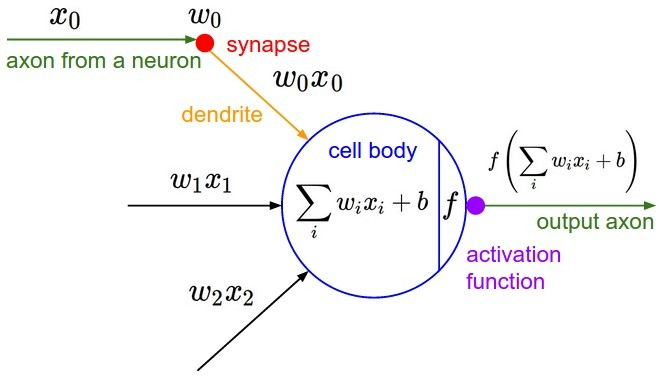

In [18]:
Image('./imgs/cell.jpg')

现在假设，这个神经元已经经过若干次迭代，其参数 $(\vec w, b)$ 已经迭代得趋于稳定。现在，神经元接收到了一个异常的输入 $\vec x$。比方说，它的某一维特征 $x_i$ 与对应的权重 $w_i$ 的乘积 $w_ix_i$ 非常大于是，ReLU 的输入就会很大，对应 ReLU 的输出也就会很大。好了，假设这个 ReLU 神经元期望的输出（ground truth）是 $y_i$，这个时候损失就会很大 $f(|y_i-\hat y_i|)$。

于是，在反向传播过程中，传递到 ReLU 的输入时的梯度就是 $g=f'(|y_i-\hat y_i|)$ 。考虑对于偏置 $b$ 有更新
$$
b \gets b - \eta g.
$$

考虑到 $g$ 是一个很大的正数，于是 $b$ 可能被更新为一个很小的负数。此后，对于常规输入（forward）来说，ReLU 的输入大概率是个负数（gradient 就是 0）。这也就是说，ReLU 大概率是关闭的。这时，梯度无法经 ReLU 反向传播至 ReLU 的输入函数。也就是说，这个神经元的参数再也不会更新了。这就是所谓的「神经元死亡」。

## `torch.clamp(x, min, max)`

$$
\begin{split}
&y=\min(\max(x, \text{min_value}), \text{max_value})\\
&y'=\begin{cases}0 & x < \text{min_value}, \\ 
    1 & \text{min_value} < x < \text{max_value}, \\
    0 & x > \text{max_value}.
    \end{cases}
\end{split}
$$

### gradient 

- https://github.com/pytorch/pytorch/blob/53fe804322640653d2dddaed394838b868ce9a26/torch/autograd/_functions/pointwise.py#L95

In [46]:
x = torch.normal(0, 1, (3, 4), requires_grad=True)
y = torch.clamp(x, -0.3, 0.3)
y.sum().backward()

In [47]:
x

tensor([[ 0.5603, -0.5051,  1.1056,  1.3461],
        [ 0.4706,  0.1713,  0.1935, -1.2677],
        [ 0.3835, -2.5004, -0.5953,  0.4064]], requires_grad=True)

In [48]:
y

tensor([[ 0.3000, -0.3000,  0.3000,  0.3000],
        [ 0.3000,  0.1713,  0.1935, -0.3000],
        [ 0.3000, -0.3000, -0.3000,  0.3000]], grad_fn=<ClampBackward1>)

In [49]:
x.grad

tensor([[0., 0., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 0.]])